# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

### Признаки

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

#### Целевой признак

- `Exited` — факт ухода клиента

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    f1_score, 
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
    make_scorer
)
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import xgboost as xgb
import catboost as ctb
import lightgbm as lgb

import warnings 
warnings.simplefilter("ignore")

## 1. Подготовка данных

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# общие характеристики и проверка на наличие выбивающихся значений
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


 - Первое, на что обращаешь внимание, это 25% клиентов с нулевым балансом на счете. Это достаточно много. Если эти люди все еще клиенты банка, то они не приносят денег банку. Потенциально, эти люди могут покинуть банк, если еще не ушли.
 - Крупных выбивающихся значений не обнаружено (есть клиент возрастом 92 года)
 - Есть странное минимальное значение предполагаемой зарплаты 11.58 при средней и близкой к ней медианной чуть больше 100 000
 - Интересно, что для кредитного рейтинга, количества недвижимости и предполагаемой зарплаты медиана и среднее очень близки по значению 5, что указывает на симметричное распределение данных в этих колонках

In [5]:
# оценка корреляций признаков
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.006495,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.006495,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Из матрицы корреляций видно, что возраст и баланс на счету коррелируют с тем, что покинет клиент банк или нет. То есть чем старше клиент и у него больше денег на счету тем больше шансов, что он покинет банк. И наоборот, чем более активен клиент, тем менее вероятно он покинет банк (эти параметры антикоррелируют).

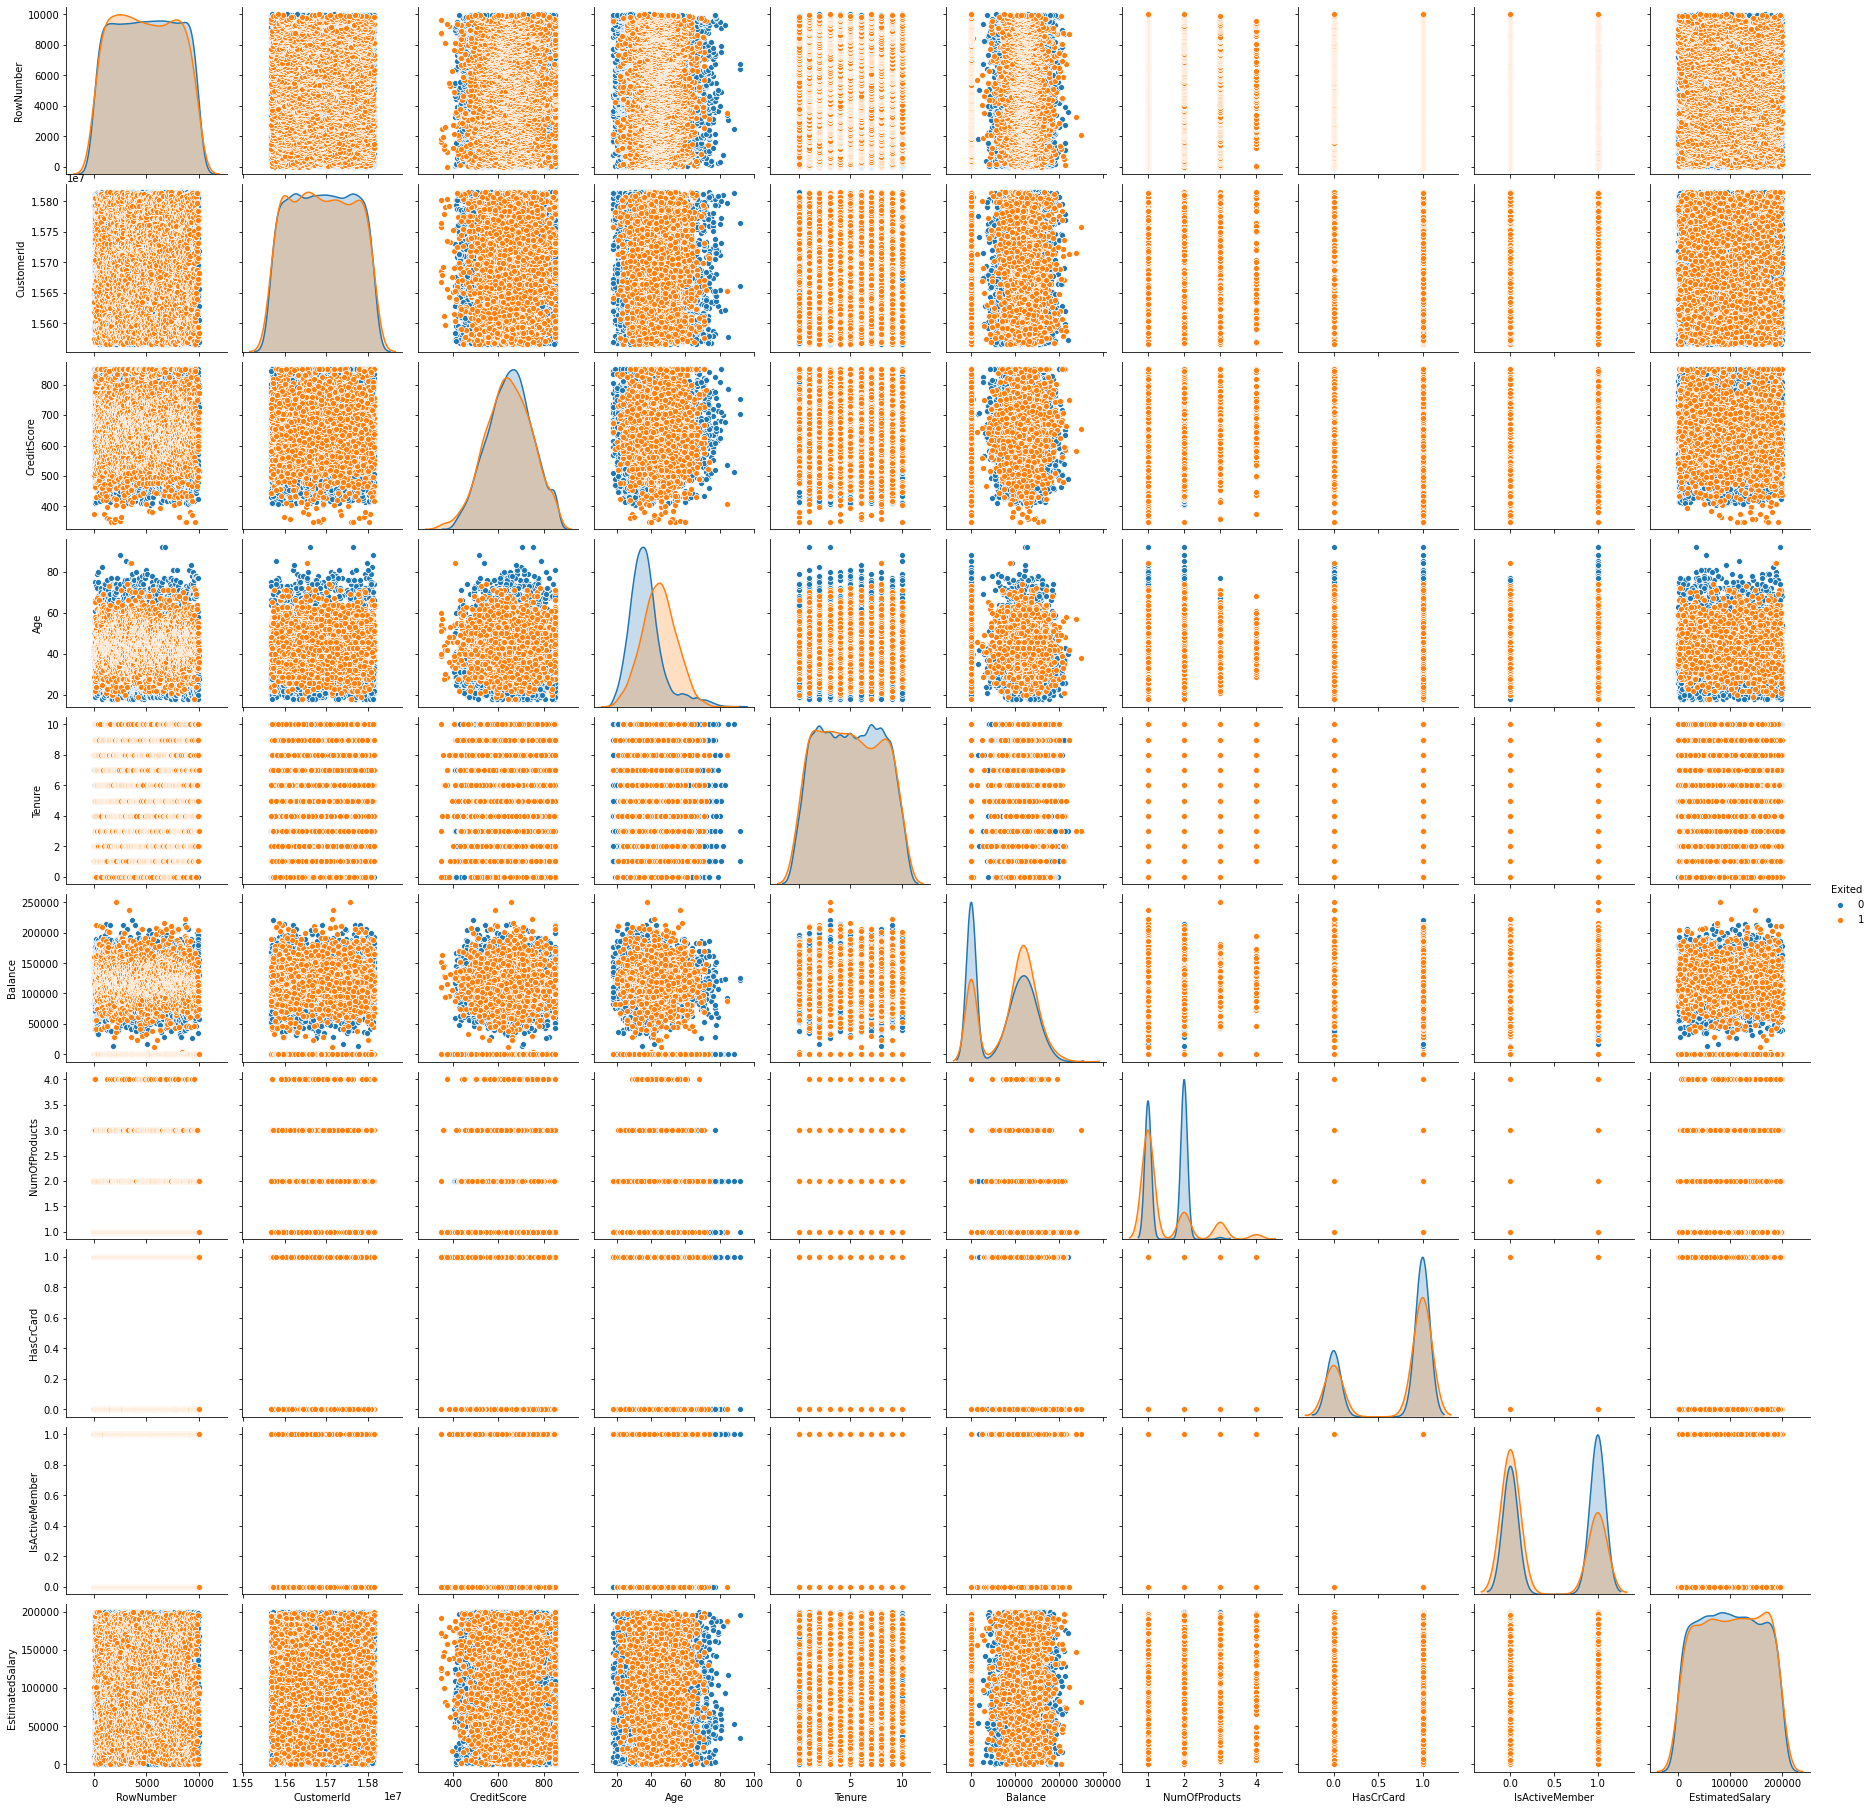

In [7]:
# визуализация корреляций
sns.pairplot(data=df, hue='Exited');

 - Визуализация нам подтвердила, что более возрастные клиенты охотнее покидают банк. Из графика виден сдвиг распределений с максимумум близким к 47 годам, для тех кто покинул банк.
 - Интересно, что клиенты с нулевым балансом продолжают оставаться в банке, а клиенты с деньгами как раз уходят - это тревожный знак для банка
 - Клиенты у кого 2 и более продукта охотнее остаются в банке, это указывает на то , что они довольны предоставляемыми банком услугами. Это же относится к активности клиентов (активный клиент остается, у неактивного больше шансов покинуть банк)
 - Кредитный рейтинг, наличие недвижимости и кредитной карты, предполагаемая зарплата не сильно влияют на решение клиента уйти или остаться.


Посмотрим данные столбика с пустыми значениями "Наличие недвижимости":

- В этом столбике около 9% пустых значений.
- Данные в этом столбике, как было отмечено ранее, симметрично распределены.
- Сам этот признак влияет на то, покинет ли клиент банк при наличии недвижимости больше 5 (то есть больше чем стреднее и медиана) и судя по графику влияет незначительно, то есть сам по себе этот признак не является критически важным.

In [8]:
# просмотр уникальных значений этого признака
df['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

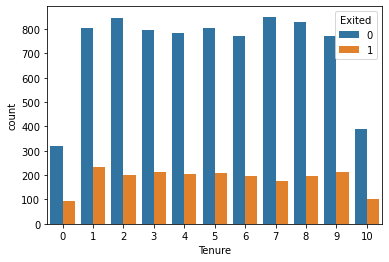

In [9]:
# построим график
sns.countplot(x='Tenure', hue='Exited', data=df);

Количество недвижимости(за исключением 0 и 10) распределено равномерно

Изучим чуть подробнее влияние наличия недвижимости

In [25]:
#создадим дополнительную колонку "наличие значений в колонке недвижимости" (потом ее уберем)
df['has_tenure'] = df['Tenure'] > 0

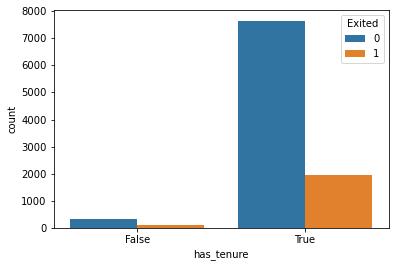

In [26]:
sns.countplot(x='has_tenure', hue='Exited', data=df);

Из гистограммы видно, что соотношение клиент ушел (1) или остался в банке (0) примерно одинаковое 1 к 4 и для пустых и непустых значений в колонке `tenure`. Поэтому эти пустые значения не являются критичными для данной задачи.

Рассмотрим нулевые значение в колонке "Баланс", которые обратили на себя внимание Их достаточно большое количество (25%). Посмотрим на гистограмму этой колонки

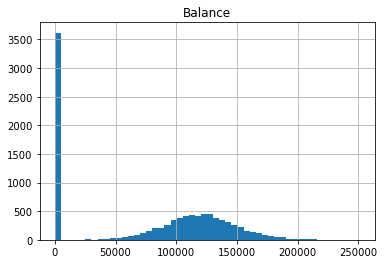

In [31]:
df.hist('Balance', bins=50);

Из гистограммы видно, что "Баланс" состоит из суперпозиции двух распределений: 25% просто нулевые значения и остальной баланс клиентов похож на нормальное распределение. И похоже эти нули реальные, а не какая-то аномалия в данных - клиенты просто вывели свои деньги со счетов, оставаясь при это все еще клиентами банка.

Посмотрим искажают ли как-то пустые значения колонки "tenure" значения колонки "Баланс" (вдруг все нулевые или вообще без нулей)

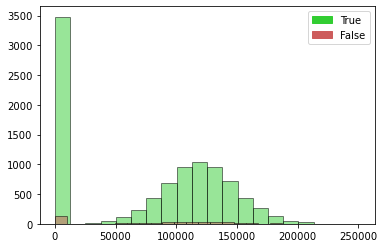

In [36]:
plt.hist(df[df["has_tenure"] == True]["Balance"], color='limegreen', alpha=0.5, 
         edgecolor="black", bins=20) 
plt.hist(df[df["has_tenure"] == False]["Balance"], color='indianred', alpha=0.5, 
         edgecolor="black", bins=20)
red_patch = patches.Patch(color='limegreen', label='True')
green_patch = patches.Patch(color='indianred', label='False')
plt.legend(handles=[red_patch, green_patch])

plt.show()

Посмотрим как влияет уход клиента на "Баланс"

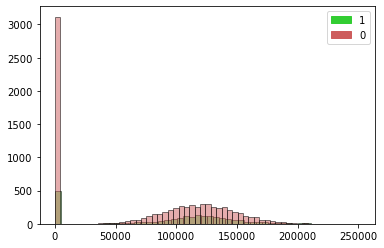

In [37]:
plt.hist(df[df["Exited"] == 1]["Balance"], color='limegreen', alpha=0.5, 
         edgecolor="black",  bins=50) 
plt.hist(df[df["Exited"] == 0]["Balance"], color='indianred', alpha=0.5, 
         edgecolor="black", bins=50)
red_patch = patches.Patch(color='limegreen', label='1')
green_patch = patches.Patch(color='indianred', label='0')
plt.legend(handles=[red_patch, green_patch])

plt.show()

Влияние пустых значений колонки `tenure` на кредитный рейтинг

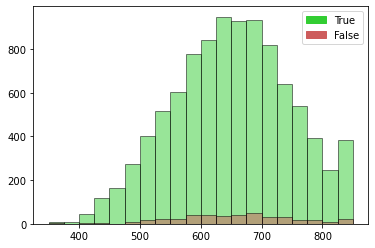

In [38]:
plt.hist(df[df["has_tenure"] == True]["CreditScore"], color='limegreen', alpha=0.5, 
         edgecolor="black",  bins=20) 
plt.hist(df[df["has_tenure"] == False]["CreditScore"], color='indianred', alpha=0.5, 
         edgecolor="black", bins=20)
red_patch = patches.Patch(color='limegreen', label='True')
green_patch = patches.Patch(color='indianred', label='False')
plt.legend(handles=[red_patch, green_patch])

plt.show()

Распределение пустых значений колонки `tenure` достаточно симметрично, за исключением самых высоких значений кредитного рейтинга

Влияние ухода клиента на кредитный рейтинг

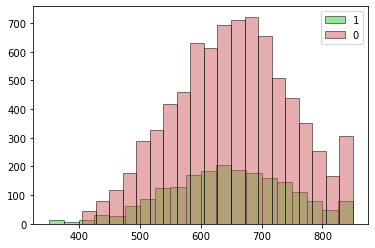

In [45]:
plt.hist(df[df["Exited"] == 1]["CreditScore"], color='limegreen', alpha=0.5, 
         edgecolor="black", bins=20, label='1') 
plt.hist(df[df["Exited"] == 0]["CreditScore"], color='indianred', alpha=0.5, 
         edgecolor="black", bins=20, label='0')
#red_patch = patches.Patch(color='limegreen', label='1')
#green_patch = patches.Patch(color='indianred', label='0')
plt.legend()

plt.show()

Клиенты с низким кредитным рейтингом (меньше 420) покинули банк

In [40]:
# удалим созданную для анализа колонку "has_tenure"
df = df.drop('has_tenure', axis=1)

### Cтратегии обработки пустых значений колонки Tenure:
- Первый подход: убрать те строки в таблице, для которых `Tenure` содержит пустые значения. Получится удаление около 9% данных
- второй вариант — удалить всю колонку. Судя по матрице корреляций и по графикам распределения для ушедших и оставшихся клиентов - этот признак не является ключевым как, например "Баланс" или "Возраст".
- третий: попробовать заполнить:
  - случайным образом от 2 до 9 с равной вероятностью случайным образом заполнить целыми числами от 2 до 9, для 0 и 10 заполнять с вероятностью в два раза меньше
  - попробовать построить самую простую ML модель, опираясь на соседние колонки, но в таком случае эти данные не будут независимыми
  - так как данные в этой колонке распределены симметрично (медиана очень близка значению среднего), то можно заменить пустые значения медианой (5). В этом случае ни среднее, ни значение медианы не изменится, но будет перекос в количестве значений 5 в таблице.
- Любое заполнение создаст дополнительный "статистический шум", что отразится на качестве модели. Поэтому ниже будем спользовать первые два подхода: удаление всей колонки и удаление 9% пустых строк

Обратимся к нашей таблице теперь как к таблице с признаками для построения моделей машинного обучения

In [46]:
# просмотр признаков
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [47]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

В этом столбце видно, что клиентов, которые ушли (1) гораздо меньше чем тех, кто остался (0). Примерно 1 к 4. То есть наблюдается дисбаланс классов. Учтем его позже

В обновленной таблице две колонки с категориальными признаками: `Gender` и `Geography`.

In [48]:
# уникальные значения колонки "Пол"
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [50]:
# уникальные значения колонки "Geography"
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Три страны: Фанция, Германия и Испания

Преобразуем категориальные признаки в численные с момощью техники прямого кодирования, или отображения (One-Hot Encoding) и удалим по одному столбцу из вновь созданных с помощью этой техники (`drop_first=True`), чтобы ихбежать дамми-ловушку

In [3]:
df_ohe = pd.get_dummies(df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1), drop_first=True)
df_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


## Вариант 1: Уберем пустые строки из таблицы

In [56]:
# удаление строк из таблицы
df_no_null = df_ohe.dropna()

In [57]:
# перенумерация
df_no_null = df_no_null.reset_index(drop=True)

In [58]:
df_no_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [59]:
df_no_null.tail(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1
9999,792,28,4,130142.79,1,1,0,38190.78,0,0,0,0


In [60]:
#Делаем отдельные датасеты для признаков features и целевого признака target
target = df_no_null['Exited']
features = df_no_null.drop('Exited', axis=1)

In [97]:
# 25% данных оставляем для тестовой выборки
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.25)

In [64]:
# проверка размера тестовой выборки после разбиения данных
features_test.shape

(2500, 11)

In [98]:
# создадим две выборки обучающую и валидационную
features_train, features_val, target_train, target_val = train_test_split(
    features_train_val, target_train_val, test_size=0.25)

In [66]:
# проверка размера валидационной выборки после разбиения данных
features_val.shape

(1875, 11)

In [67]:
# проверка размера обучающей выборки после разбиения данных
features_train.shape

(5625, 11)

Проведем стандартизацию данных, воспользуясь методом масштабирования. На первом шаге создадим список с названиями колонок, которые требуют масштабирования.

In [10]:
# список названий колонок с признаками, которые требуют стандартизации
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [9]:
# создадим объект структуры для стандартизации данных
scaler = StandardScaler()

In [99]:
# настроим его на обучающих данных, т. е. вычислим среднее и дисперсию
scaler.fit(features_train[numeric])

StandardScaler()

In [100]:
# преобразуем обучающую выборку функцией transform()
features_train.loc[:, numeric] = scaler.transform(features_train[numeric])

In [101]:
# преобразуем валидационную выборку функцией transform()
features_val.loc[:, numeric] = scaler.transform(features_val[numeric])

# преобразуем тестовую выборку функцией transform()
features_test.loc[:, numeric] = scaler.transform(features_test[numeric])

In [102]:
# просмотр как выглядит обучающая выборка после всех преобразований
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2600,0.300158,-1.412808,10,-1.255058,3,1,0,0.959493,0,0,0
7668,-1.295572,2.103373,6,0.904474,2,1,1,-0.958765,1,0,1
9458,-1.326658,-0.272425,8,1.299863,2,1,0,0.965309,0,0,1
3823,-0.249022,-0.747584,8,0.812289,1,1,0,-0.068558,0,0,1
240,0.113644,-0.082361,4,-1.255058,2,1,0,0.632559,0,1,1


## 2. Исследование задачи
Мы выяснили, что целевой признак несбалансирован. Дисбаланс примерно 1 к 4. На первом этапе обучим модели без учета диссбаланса классов. Возьмем две модели машинного обучения: Случайный лес и Логистическую регрессию

### Случайный лес

In [103]:
# Построим объект класса RandomForestClassifier, используя параметры по умолчанию
model_rf = RandomForestClassifier() 

In [104]:
# запускаем обучение на обучающей выборке
model_rf.fit(features_train, target_train)

# предсказываем значения целевого признака валидационных данных
predicted_val_rf = model_rf.predict(features_val)

In [105]:
# Посчитаем вероятность классов
probabilities_val_rf = model_rf.predict_proba(features_val)

# Значения вероятностей класса «1» 
probabilities_one_val_rf = probabilities_val_rf[:, 1]

# Выясним, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 
auc_roc_rf = roc_auc_score(target_val, probabilities_one_val_rf)

In [4]:
def classification_report(y_test, pred_test):
    """Вычислим значение точности, полноты, F1-меры и AUC-ROC константной модели"""
    
    accuracy = accuracy_score(y_test, pred_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1 = f1_score(y_test, pred_test)
    
    rep_df = pd.DataFrame(data=[accuracy, 
                                recall, 
                                precision, 
                                f1], 
                      index=['accuracy', 'recall', 'precision', 'f1'], 
                      columns=['Значения метрик'])
    return rep_df

In [114]:
# делаем отчет по основным метрикам модели
print('Отчет по метрикам\n\n {}'.format(classification_report(target_val, predicted_val_rf)))
#Площадь по ROC-кривой
print('Площадь под кривой ошибок (ROC-кривой): {:.3f}'.format(auc_roc_rf))

Отчет по метрикам

            Значения метрик
accuracy          0.864000
recall            0.457995
precision         0.754464
f1                0.569983
Площадь под кривой ошибок (ROC-кривой): 0.840


### Логистическая регрессия

In [115]:
# создаем объекта класса LogisticRegression c гиперпараметрами по умолчанию
model_lr = LogisticRegression(solver='liblinear')

In [116]:
# запускаем обучение на обучающей выборке
model_lr.fit(features_train, target_train)

# предсказываем значения целевого признака валидационных данных
predicted_val_lr = model_lr.predict(features_val)

In [117]:
# Посчитаем вероятность классов
probabilities_val_lr = model_lr.predict_proba(features_val)

# Значения вероятностей класса «1» 
probabilities_one_val_lr = probabilities_val_lr[:, 1]

#Выясним, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 
auc_roc_lr = roc_auc_score(target_val, probabilities_one_val_lr)

In [118]:
# делаем отчет по основным метрикам модели
print('Отчет по метрикам\n\n {}'.format(classification_report(target_val, predicted_val_lr)))
#Площадь по ROC-кривой
print('Площадь под кривой ошибок (ROC-кривой): {:.3f}'.format(auc_roc_lr))

Отчет по метрикам

            Значения метрик
accuracy          0.806933
recall            0.214092
precision         0.523179
f1                0.303846
Площадь под кривой ошибок (ROC-кривой): 0.745


### Промежуточные выводы
Из двух моделей с гиперпараметрами по умолчанию наибольшое значение F1-меры показывает "Случайный лес" (0.57), но значение мектрики не доходит до требуемых 0.59.
Логистическая регрессия показывает достаточно высокое значение метрики точности (0.81) и AUC-ROC (0.745), но плохо предсказывает целевой признак со значением класса 1 (F1 мера равна 0.3 для класса 1)

## 3. Борьба с дисбалансом

Как было отмечено выше, наблюдается дисбаланс классов целевого признака. Мы можем его убрать с помощью нескольких подходов:

- Взвешивание классов: придадим объектам редкого класса (1) больший вес
- Увеличение выборки (upsampling)
- Уменьшение выборки (downsamling)

### 3.1 Balanced. Взвешивание классов

### Случайный лес

In [119]:
# Построим объект класса RandomForestClassifier с учетом взвешивания class_weight='balanced'
model_rf_b = RandomForestClassifier(class_weight='balanced')

In [120]:
# запускаем обучение на обучающей выборке
model_rf_b.fit(features_train, target_train)

# предсказываем значения целевого признака валидационных данных
predicted_val_rf_b = model_rf_b.predict(features_val)

In [121]:
# Посчитаем вероятность классов
probabilities_val_rf_b = model_rf_b.predict_proba(features_val)

# Значения вероятностей класса «1» 
probabilities_one_val_rf_b = probabilities_val_rf_b[:, 1]

#Выясним, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 
auc_roc_rf_b = roc_auc_score(target_val, probabilities_one_val_rf_b)

In [122]:
# делаем отчет по основным метрикам модели
print('Отчет по метрикам\n\n {}'.format(classification_report(target_val, predicted_val_rf_b)))
#Площадь по ROC-кривой
print('Площадь под кривой ошибок (ROC-кривой): {:.3f}'.format(auc_roc_rf_b))

Отчет по метрикам

            Значения метрик
accuracy          0.868800
recall            0.455285
precision         0.788732
f1                0.577320
Площадь под кривой ошибок (ROC-кривой): 0.845


- "Взвешивание" немного улучшило F1 метрику (0.577 против 0.569 для класса "1")
- Метрика точности осталась без изменений: 0.86
- Метрика AUC-ROC (площадь под кривой ошибок) незначительно улучшилась с 0.840 до 0.845

### Логистическая регрессия

In [123]:
# создаем объекта класса LogisticRegression c гиперпараметрами по умолчанию и с учетом взвешивания классов
model_lr_b = LogisticRegression(solver='liblinear', class_weight='balanced')

In [124]:
# запускаем обучение на обучающей выборке
model_lr_b.fit(features_train, target_train)

# предсказываем значения целевого признака валидационных данных
predicted_val_lr_b = model_lr_b.predict(features_val)

In [125]:
# Посчитаем вероятность классов
probabilities_val_lr_b = model_lr_b.predict_proba(features_val)

# Значения вероятностей класса «1» 
probabilities_one_val_lr_b = probabilities_val_lr_b[:, 1]

#Выясним, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 
auc_roc_lr_b = roc_auc_score(target_val, probabilities_one_val_lr_b)

In [126]:
# делаем отчет по основным метрикам модели
print('Отчет по метрикам\n\n {}'.format(classification_report(target_val, predicted_val_lr_b)))
#Площадь по ROC-кривой
print('Площадь под кривой ошибок (ROC-кривой): {:.3f}'.format(auc_roc_lr_b))

Отчет по метрикам

            Значения метрик
accuracy          0.707200
recall            0.688347
precision         0.369186
f1                0.480605
Площадь под кривой ошибок (ROC-кривой): 0.748


- "Взвешивание" значительно улучшило значение F1-меры для логистической регрессиии с 0.3 до 0.48
- При этом пострадала метрика точности - уменьшилась с 0.8 до 0.7
- Метрика AUC-ROC немного увеличилась с 0.745 до 0.748

### Промежуточные выводы:
- Использование "balanced" немного улучшило F1-меру для модели "Случайного леса"
- Взвешивание классов значительно улучшило значение F1-меры для логистической регрессии (с 0.3 без взвешивания классов, до 0.48 со взвешиванием).
- При этом площадь под кривой ошибок поменялась незначительно(0.745 против 0.748)

### Upsampling
Создадим функцию upsample, которая будет преобразовывать нашу обучающую выборку:

- На первом этапе разделим выборку с признаками, на те у которых целевой признак равен 0 и те, для которых целевой признак равен единице;
- Потом скопируем несколько раз признаки, для которых целевой признак 1.
- Создадим новую объединенную выборку и перемешаем в ней данные.
- 8 нулей и 2 единицы: соотношение классов 1 к 4. Будем подавать коээфициент 4 на вход нашей функции чтобы количество нулей и 1 стало одинаковым в новой выборке

In [5]:
def up_sample(features, target, repeat):
        features_0 = features[target == 0]
        features_1 = features[target == 1]
        target_0 = target[target == 0]
        target_1 = target[target == 1]

        features_upsampled = pd.concat([features_0] + [features_1] * repeat)
        target_upsampled = pd.concat([target_0] + [target_1] * repeat)

        features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled)
        
        return features_upsampled, target_upsampled

In [148]:
features_upsampled, target_upsampled = up_sample(features_train, target_train, 4)

In [149]:
features_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9084 entries, 7937 to 3056
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9084 non-null   float64
 1   Age                9084 non-null   float64
 2   Tenure             9084 non-null   int64  
 3   Balance            9084 non-null   float64
 4   NumOfProducts      9084 non-null   int64  
 5   HasCrCard          9084 non-null   int64  
 6   IsActiveMember     9084 non-null   int64  
 7   EstimatedSalary    9084 non-null   float64
 8   Geography_Germany  9084 non-null   uint8  
 9   Geography_Spain    9084 non-null   uint8  
 10  Gender_Male        9084 non-null   uint8  
dtypes: float64(4), int64(4), uint8(3)
memory usage: 665.3 KB


In [150]:
# соотношение классов до применения функции upsampled
target_train.value_counts()

0    4472
1    1153
Name: Exited, dtype: int64

In [151]:
# соотношение классов после применения функции
target_upsampled.value_counts()

1    4612
0    4472
Name: Exited, dtype: int64

Классы стали сбалансированными.

### Случайный лес
Проведем подбор параметров для "Случайного леса". Так как гиперпараметров для этого алгоритма достаточно много, то сфокусируемся на трех: 
- `n_estimamators` - количество деревьев
- `max_features` - число признаков, по которым ищется разбиение
- `min_samples_leaf` — минимальное количество образцов в листе

In [154]:
# создадим словарь с гипперпараметрами и их значениями
grid = {'n_estimators': range(10, 210, 10),
        'max_features': [2, 4, 8],
        'min_samples_leaf': [2, 3, 4, 5]} 

# пустой список, в который будут записываться значения метрики F1
f1_rf = []

# пустой список, в который будет записоваться значение метрики AUC-ROC
auc_roc_rf = []

# создаем объекта класса RandomForestClassifier
rfc = RandomForestClassifier() 

# Организуем цикл по сетке параметров. 
for g in ParameterGrid(grid):
    
    #распаковывваем словарь и передаем его элемент в функцию .set_params 
    rfc.set_params(**g)  
    # запускаем обучение на обучающей выборке
    rfc.fit(features_upsampled, target_upsampled)
    
    
    # предсказываем значения целевого признака валидационных данных
    predictions_val = rfc.predict(features_val)
    
    # F1-мера - среднее гармоническое полноты и точности. Важна для правильного прогнозирования класса 1
    f1_score_rf = f1_score(target_val, predictions_val)
    
    # Посчитаем вероятность классов
    probabilities_val_rfc = rfc.predict_proba(features_val)
    # Значения вероятностей класса «1» 
    probabilities_one_val_rfc = probabilities_val_rfc[:, 1]

    
    # AUC-ROC площадь под кривой ошибок, показывает насколько модель далека/близка от/к случайной (случайная 0.5)
    auc_roc_score_rf = roc_auc_score(target_val, probabilities_one_val_rfc)
    
    # записываем значение метрик в соответствующие списки
    f1_rf.append(f1_score_rf)
    auc_roc_rf.append(auc_roc_score_rf)
    #print (f1_score_rf, auc_roc_score_rf)
    
# Лучшие значения гиперпараметров для валидационной выборки 
best_idx = np.argmax(f1_rf) # выбираем с максимальным значением F1-меры
print(f1_rf[best_idx], auc_roc_rf[best_idx], ParameterGrid(grid)[best_idx])

0.6376811594202899 0.8445018480729296 {'n_estimators': 30, 'min_samples_leaf': 3, 'max_features': 4}


Лучшая модель "Случайного леса" обладает параметрами: `n_estimators=30`, `max_features=4`, `min_samples_leaf=3`. При таких параметрах F1-мера равна 0.637 на валидационной выборке (при требуемых 0.59). AUC-ROC при этом равна 0.844, что примерно развнозачно методу без применения подхода "upsampling" (0.845)

### Логистическая регрессия
Выбререм несколько гиперпараметров логистической регрессии для насройки модели: параметр регуляризации `C`, `dual` — оптимизация прямая или двойственная, `max_iter` — максимальное количество итераций. Выберем алгоритм использования в задаче оптимизации `solver='liblinear'` — рекомендованный `slkearn` библиотекой для небольших датасетов.

In [153]:
# создадим словарь с гипперпараметрами и их значениями
grid = {'C': [1.0, 2.5, 5, 10, 100, 1000],
        'dual': [True, False],
        'max_iter': [100, 110, 120, 130, 140]} # , np.logspace(-1, 4, 10)'max_features': [2, 4, 8]

# пустой список, в который будут записываться значения метрики F1
f1_lr = []

# пустой список, в который будет записоваться значение метрики AUC-ROC
auc_roc_lr = []

# создаем объекта класса LogisticRegression

lr = LogisticRegression(solver='liblinear') #solver = 'liblinear'
# Организуем цикл по сетке параметров. 
for g in ParameterGrid(grid):
    
    #распаковывваем словарь и передаем его элемент в функцию .set_params 
    lr.set_params(**g)  
    # запускаем обучение на обучающей выборке
    lr.fit(features_upsampled, target_upsampled)
    
    
    # предсказываем значения целевого признака валидационных данных
    predictions_val = lr.predict(features_val)
    
    # F1-мера - среднее гармоническое полноты и точности. Важна для правильного прогнозирования класса 1
    f1_score_lr = f1_score(target_val, predictions_val)
 
    # Посчитаем вероятность классов
    probabilities_val_lr = lr.predict_proba(features_val)
    # Значения вероятностей класса «1» 
    probabilities_one_val_lr = probabilities_val_lr[:, 1]

    # AUC-ROC площадь под кривой ошибок, показывает насколько модель далека/близка от/к случайной (случайная 0.5)
    auc_roc_score_lr = roc_auc_score(target_val, probabilities_one_val_lr)
    
    # записываем значение метрик в соответствующие списки
    f1_lr.append(f1_score_lr)
    auc_roc_lr.append(auc_roc_score_lr)
    #print (f1_score_lr, auc_roc_score_lr)
    
# Лучшие значения гиперпараметров для валидационной выборки 
best_idx = np.argmax(f1_lr) # выбираем с максимальным значением F1-меры
print(f1_lr[best_idx], auc_roc_lr[best_idx], ParameterGrid(grid)[best_idx])

0.48448448448448456 0.7474636233746135 {'max_iter': 120, 'dual': True, 'C': 5}


Техника "upsampling" не помогла помогла с улучшением значения F1-меры для модели логистической регрессии: F1 стала 0.48 против 0.57 при применениии техники "взешивания" классов, при этом значение AUC-ROC также снизилось: 0.74 против 0.845

### Downsampling. Уменьшение выборки

Попробуем третий вариант решения проблемы несбалансированных классов: данные с признаками, для котрых целевой признак 1 (меньший класс) оставим без изменения, а данные для котрых целевой признак 0 сократим согласно пропорции дисбаланса. Создадим функцию `down_sample`

In [6]:
def down_sample(features, target, fraction):
        features_0 = features[target == 0]
        features_1 = features[target == 1]
        target_0 = target[target == 0]
        target_1 = target[target == 1]
        
        features_downsampled = pd.concat([features_0.sample(frac=fraction)] + [features_1])
        target_downsampled = pd.concat([target_0.sample(frac=fraction)] + [target_1])
        
        features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled)
        
        return features_downsampled, target_downsampled

In [158]:
features_downsampled, target_downsampled = down_sample(features_train, target_train, 0.25)

In [159]:
target_downsampled.value_counts()

1    1153
0    1118
Name: Exited, dtype: int64

Классы примерно сбалансированы теперь.

### Случайный лес

In [160]:
# создадим словарь с гипперпараметрами и их значениями
grid = {'n_estimators': range(10, 210, 10),
        'max_features': [2, 4, 8],
        'min_samples_leaf': [2, 3, 4, 5]} 

# пустой список, в который будут записываться значения метрики F1
f1_rf = []

# пустой список, в который будет записоваться значение метрики AUC-ROC
auc_roc_rf = []

# создаем объекта класса RandomForestClassifier
rfc = RandomForestClassifier() 

# Организуем цикл по сетке параметров. 
for g in ParameterGrid(grid):
    
    #распаковывваем словарь и передаем его элемент в функцию .set_params 
    rfc.set_params(**g)  
    # запускаем обучение на обучающей выборке
    rfc.fit(features_downsampled, target_downsampled)
    
    
    # предсказываем значения целевого признака валидационных данных
    predictions_val = rfc.predict(features_val)
    
    # F1-мера - среднее гармоническое полноты и точности. Важна для правильного прогнозирования класса 1
    f1_score_rf = f1_score(target_val, predictions_val)

    # Посчитаем вероятность классов
    probabilities_val_rfc = rfc.predict_proba(features_val)
    # Значения вероятностей класса «1» 
    probabilities_one_val_rfc = probabilities_val_rfc[:, 1]

    # AUC-ROC площадь под кривой ошибок, показывает насколько модель далека/близка от/к случайной (случайная 0.5)
    auc_roc_score_rf = roc_auc_score(target_val, probabilities_one_val_rfc)
    
    # записываем значение метрик в соответствующие списки
    f1_rf.append(f1_score_rf)
    auc_roc_rf.append(auc_roc_score_rf)
    #print (f1_score_rf, auc_roc_score_rf)
    
# Лучшие значения гиперпараметров для валидационной выборки 
best_idx = np.argmax(f1_rf) # выбираем с максимальным значением F1-меры
print(f1_rf[best_idx], auc_roc_rf[best_idx], ParameterGrid(grid)[best_idx])

0.5801838610827375 0.8514289724570554 {'n_estimators': 160, 'min_samples_leaf': 4, 'max_features': 4}


Лучшая модель "Случайного леса" обладает параметрами: `n_estimators=160`, `max_features=4`, `min_samples_leaf=4`. При таких параметрах F1-мера равна 0.58 на валидационной выборке (при требуемых 0.59) и меньше, чем при применеии техники upsampling. AUC-ROC при этом равна 0.85, что незначительно больше, чем с применением подхода upsampling.

### Логистическая регрессия

In [161]:
# создадим словарь с гипперпараметрами и их значениями
grid = {'C': [1.0, 2.5, 5, 10, 100, 1000],
        'dual': [True, False],
        'max_iter': [100, 110, 120, 130, 140]}
# пустой список, в который будут записываться значения метрики F1
f1_lr = []

# пустой список, в который будет записоваться значение метрики AUC-ROC
auc_roc_lr = []

# создаем объекта класса LogisticRegression

lr = LogisticRegression(solver='liblinear') #solver = 'liblinear'
# Организуем цикл по сетке параметров. 
for g in ParameterGrid(grid):
    
    #распаковывваем словарь и передаем его элемент в функцию .set_params 
    lr.set_params(**g)  
    # запускаем обучение на обучающей выборке
    lr.fit(features_downsampled, target_downsampled)
    
    # предсказываем значения целевого признака валидационных данных
    predictions_val = lr.predict(features_val)
    
    # F1-мера - среднее гармоническое полноты и точности. Важна для правильного прогнозирования класса 1
    f1_score_lr = f1_score(target_val, predictions_val)
 

    # Посчитаем вероятность классов
    probabilities_val_lr = lr.predict_proba(features_val)
    # Значения вероятностей класса «1» 
    probabilities_one_val_lr = probabilities_val_lr[:, 1]

    # AUC-ROC площадь под кривой ошибок, показывает насколько модель далека/близка от/к случайной (случайная 0.5)
    auc_roc_score_lr = roc_auc_score(target_val, probabilities_one_val_lr)
    
    # записываем значение метрик в соответствующие списки
    f1_lr.append(f1_score_lr)
    auc_roc_lr.append(auc_roc_score_lr)
    #print (f1_score_lr, auc_roc_score_lr)
    
# Лучшие значения гиперпараметров для валидационной выборки 
best_idx = np.argmax(f1_lr) # выбираем с максимальным значением F1-меры
print(f1_lr[best_idx], auc_roc_lr[best_idx], ParameterGrid(grid)[best_idx])

0.4833659491193738 0.7451440849069846 {'max_iter': 130, 'dual': True, 'C': 5}


Техника downsampling незначительно помогла с улучшением значения F1-меры для модели логистической регрессии: F1 стала 0.483 против 0.484 при применениии техники upsampling классов, при этом значение AUC-ROC стало немного хуже: 0.747 против 0.745

### Выводы:
Максимальное значение F1-меры получилось для модели "Случайного леса" с применением техники upsampling с параметрами: `n_estimators=30`, `max_features=4`. При таких параметрах F1-мера равна 0.637 на валидационной выборке (при требуемых 0.59). AUC-ROC при этом равна 0.844

## 4. Тестирование модели

Проведем тестирование этой лучшей модели

In [162]:
rfc_best = RandomForestClassifier(n_estimators=30, max_features=4, min_samples_leaf=3) 

In [163]:
# запускаем обучение на обучающей выборке
rfc_best.fit(features_upsampled, target_upsampled)

RandomForestClassifier(max_features=4, min_samples_leaf=3, n_estimators=30)

In [164]:
# проверка работы модели на тестовой выборке
predictions_test_rfc_best = rfc_best.predict(features_test)

In [165]:
# Посчитаем вероятность классов
probabilities_test_rfc_best = rfc_best.predict_proba(features_test)
# Значения вероятностей класса «1» 
probabilities_one_val_rfc_best = probabilities_test_rfc_best[:, 1]

#Выясним, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 
auc_roc_rfc_best = roc_auc_score(target_test, probabilities_one_val_rfc_best)

In [166]:
# делаем отчет по основным метрикам модели
print('Отчет по метрикам\n\n {}'.format(classification_report(target_test, predictions_test_rfc_best)))
print('AUC-ROC площадь под кривой ошибок: {:.3f}'.format(auc_roc_rfc_best))

Отчет по метрикам

            Значения метрик
accuracy          0.825600
recall            0.607767
precision         0.572212
f1                0.589454
AUC-ROC площадь под кривой ошибок: 0.842


- На тестовой выборке значение F1-меры равно 0.589;
- При этом AUC-ROC площадь под кривой ошибок: 0.842

## 2 вариант. Уберем колонку с пустыми значениями

In [167]:
df_no_tenure = df_ohe.drop('Tenure', axis=1)
df_no_tenure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Balance            10000 non-null  float64
 3   NumOfProducts      10000 non-null  int64  
 4   HasCrCard          10000 non-null  int64  
 5   IsActiveMember     10000 non-null  int64  
 6   EstimatedSalary    10000 non-null  float64
 7   Exited             10000 non-null  int64  
 8   Geography_Germany  10000 non-null  uint8  
 9   Geography_Spain    10000 non-null  uint8  
 10  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(6), uint8(3)
memory usage: 654.4 KB


In [168]:
df_no_tenure.head(3)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,159660.80,3,1,0,113931.57,1,0,0,0


In [169]:
#Делаем отдельные датасеты для признаков features и целевого признака target
target_no_tenure = df_no_tenure['Exited']
features_no_tenure = df_no_tenure.drop('Exited', axis=1)

In [170]:
# 20% данных оставляем для тестовой выборки
(features_no_tenure_train_val, features_no_tenure_test, 
              target_no_tenure_train_val, target_no_tenure_test) = train_test_split(
                                                        features_no_tenure, target_no_tenure, test_size=0.20)

In [171]:
# проверка размера тестовой выборки после разбиения данных
features_no_tenure_test.shape

(2000, 10)

In [172]:
# создадим две выборки обучающую и валидационную
features_no_tenure_train, features_no_tenure_val, target_no_tenure_train, target_no_tenure_val = train_test_split(
    features_no_tenure_train_val, target_no_tenure_train_val, test_size=0.25)

In [173]:
# проверка размера валидационной выборки после разбиения данных
features_no_tenure_val.shape

(2000, 10)

In [174]:
# проверка размера обучающей выборки после разбиения данных
features_no_tenure_train.shape

(6000, 10)

Проведем стандартизацию данных, воспользуясь методом масштабирования. Объект структуры для стандартизации данных мы уже создавали выше `scaler=StandardScaler()`. Поэтому будем его испотльзовать, для настройки новых обучающих данных

In [175]:
# настроим его на обучающих данных, т. е. вычислим среднее и дисперсию
scaler.fit(features_no_tenure_train[numeric])  

# преобразуем обучающую выборку функцией transform()
features_no_tenure_train[numeric] = scaler.transform(features_no_tenure_train[numeric])

In [176]:
# преобразуем валидационную выборку функцией transform()
features_no_tenure_val[numeric] = scaler.transform(features_no_tenure_val[numeric])

# преобразуем тестовую выборку функцией transform()
features_no_tenure_test[numeric] = scaler.transform(features_no_tenure_test[numeric])

Так как присутствует дисбаланс классов, и выше мы увидели, что техника upsample для "Случайного леса" работает лучше всего в борьбе с этим дисбалансом, то применим ее далее

In [178]:
features_no_tenure_upsampled, target_no_tenure_upsampled = up_sample(features_no_tenure_train,
                                                                        target_no_tenure_train, 4)

In [179]:
# проверяем как отработала функция, ихбавились от дисбаланса или нет
target_no_tenure_upsampled.value_counts()

0    4811
1    4756
Name: Exited, dtype: int64

In [180]:
features_no_tenure_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9567 entries, 2542 to 7583
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9567 non-null   float64
 1   Age                9567 non-null   float64
 2   Balance            9567 non-null   float64
 3   NumOfProducts      9567 non-null   int64  
 4   HasCrCard          9567 non-null   int64  
 5   IsActiveMember     9567 non-null   int64  
 6   EstimatedSalary    9567 non-null   float64
 7   Geography_Germany  9567 non-null   uint8  
 8   Geography_Spain    9567 non-null   uint8  
 9   Gender_Male        9567 non-null   uint8  
dtypes: float64(4), int64(3), uint8(3)
memory usage: 626.0 KB


In [181]:
# создадим словарь с гипперпараметрами и их значениями
grid = {'n_estimators': range(10, 210, 10),
        'max_features': [2, 4, 8],
        'min_samples_leaf': [2, 3, 4, 5]} 

# пустой список, в который будут записываться значения метрики F1
f1_rf = []

# пустой список, в который будет записоваться значение метрики AUC-ROC
auc_roc_rf = []

# создаем объекта класса RandomForestClassifier
rfc = RandomForestClassifier() 

# Организуем цикл по сетке параметров. 
for g in ParameterGrid(grid):
    
    #распаковывваем словарь и передаем его элемент в функцию .set_params 
    rfc.set_params(**g)  
    # запускаем обучение на обучающей выборке
    rfc.fit(features_no_tenure_upsampled, target_no_tenure_upsampled)
    
    
    # предсказываем значения целевого признака валидационных данных
    predictions_no_tenure_val = rfc.predict(features_no_tenure_val)
    
    # F1-мера - среднее гармоническое полноты и точности. Важна для правильного прогнозирования класса 1
    f1_score_rf = f1_score(target_no_tenure_val, predictions_no_tenure_val)

    # Посчитаем вероятность классов
    probabilities_no_tenure_val = rfc.predict_proba(features_no_tenure_val)
    # Значения вероятностей класса «1» 
    probabilities_no_tenure_one_val = probabilities_no_tenure_val[:, 1]
    
    # AUC-ROC площадь под кривой ошибок, показывает насколько модель далека/близка от/к случайной (случайная 0.5)
    auc_roc_score_rf = roc_auc_score(target_no_tenure_val, probabilities_no_tenure_one_val)
    
    # записываем значение метрик в соответствующие списки
    f1_rf.append(f1_score_rf)
    auc_roc_rf.append(auc_roc_score_rf)
    #print (f1_score_rf, auc_roc_score_rf)
    
# Лучшие значения гиперпараметров для валидационной выборки 
best_idx = np.argmax(f1_rf) # выбираем с максимальным значением F1-меры
print(f1_rf[best_idx], auc_roc_rf[best_idx], ParameterGrid(grid)[best_idx])

0.6521239954075775 0.8536858447172349 {'n_estimators': 20, 'min_samples_leaf': 3, 'max_features': 4}


- Лучшая модель получилась с другими параметрами на данных без учета колонки `tenure`: `n_estimators=20`, `min_samples_leaf=3`, `max_features=2`
- F1-мера = 0.65, AUC-ROC = 0.85

Проведем проверку нашей модели на тестовой выборке

In [182]:
rfc_no_tenure_best = RandomForestClassifier(n_estimators=20, max_features=4, min_samples_leaf=3) 

In [183]:
# запускаем обучение на обучающей выборке
rfc_no_tenure_best.fit(features_no_tenure_upsampled, target_no_tenure_upsampled)

RandomForestClassifier(max_features=4, min_samples_leaf=3, n_estimators=20)

In [184]:
# предсказываем значения на тестовой выборке
predictions_no_tenure_test_rfc_best = rfc_no_tenure_best.predict(features_no_tenure_test)

In [185]:
# Посчитаем вероятность классов
probabilities_no_tenure_test_rfc_best = rfc_no_tenure_best.predict_proba(features_no_tenure_test)

# Значения вероятностей класса «1» 
probabilities_no_tenure_one_test_rfc_best = probabilities_no_tenure_test_rfc_best[:, 1]

# Выясним, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 
auc_roc_no_tenure_rfc_best = roc_auc_score(target_no_tenure_test, probabilities_no_tenure_one_test_rfc_best)

In [187]:
# делаем отчет по основным метрикам модели
print('Отчет по метрикам\n\n {}'.format(classification_report(target_no_tenure_test,
                                                                    predictions_no_tenure_test_rfc_best)))
print('AUC-ROC площадь под кривой ошибок: {:.3f}'.format(auc_roc_no_tenure_rfc_best))

Отчет по метрикам

            Значения метрик
accuracy           0.83600
recall             0.59204
precision          0.59204
f1                 0.59204
AUC-ROC площадь под кривой ошибок: 0.830


Значение F1-меры на тестовой выборке равно 0.592, значение площади под кривой ошибок: 0.83

## 3 вариант. Заполним колонку с пустыми значениями предсказанными

In [7]:
df_inputed = df_ohe.copy()
df_inputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


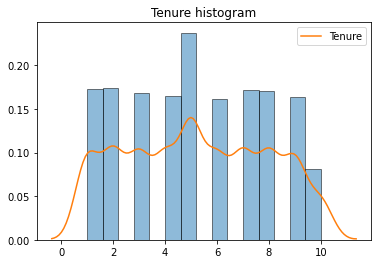

In [312]:
plt.hist(df_inputed['Tenure'], edgecolor='black', density=True, bins=15, alpha=0.5)
plt.title('Tenure histogram')
sns.kdeplot(df_inputed['Tenure']);

Можно создать простую модель линейной регрессии для вычисления недостающих значений `Tenure`. Однако нужно быть уверенным, что эти приблизительные значения близки к истине.

Чтобы получить представление о точности модели, можно использовать машинное обучение и разделить данные на две части: для тестирования и обучения. Обучающий набор — это часть данных, используемых для обучения модели. Для проверки модели используется второй набор. Обычно для обучения модели используется 75% данных, а для проверки модели — 25%.

In [209]:
df_inputed.query('Tenure != 0')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
29,411,29,0,59697.17,2,1,1,53483.21,0,0,0,1
35,475,45,0,134264.04,1,1,0,27822.99,1,0,0,0
57,725,19,0,75888.20,1,0,0,45613.75,0,1,0,1
72,657,37,0,163607.18,1,0,1,44203.55,0,0,1,0
127,625,56,0,148507.24,1,1,0,46824.08,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9793,772,42,0,101979.16,1,1,0,90928.48,0,1,0,0
9799,653,46,0,119556.10,1,1,0,78250.13,1,0,0,1
9843,646,24,0,92398.08,1,1,1,18897.29,0,1,0,1
9868,718,43,0,93143.39,1,1,0,167554.86,0,0,0,0


In [11]:
X = df_inputed.query('Tenure != 0').drop(['Tenure'], axis=1)#.to_numpy()
y = df_inputed.query('Tenure != 0')['Tenure']

lin_reg = LinearRegression()

scaler.fit(X[numeric])
X[numeric] = scaler.transform(X[numeric])

In [12]:
X = X.to_numpy()
lin_reg.fit(X, y)

LinearRegression()

### Создание маски строк, в которых используются отсутствующие значения

In [13]:
mask = df_inputed['Tenure'] == 0
mask

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: Tenure, Length: 10000, dtype: bool

Теперь примените эту маску только к столбцам, которые использовались в качестве `X` в модели.

In [248]:
df_inputed.loc[mask]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
29,411,29,0,59697.17,2,1,1,53483.21,0,0,0,1
35,475,45,0,134264.04,1,1,0,27822.99,1,0,0,0
57,725,19,0,75888.20,1,0,0,45613.75,0,1,0,1
72,657,37,0,163607.18,1,0,1,44203.55,0,0,1,0
127,625,56,0,148507.24,1,1,0,46824.08,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9793,772,42,0,101979.16,1,1,0,90928.48,0,1,0,0
9799,653,46,0,119556.10,1,1,0,78250.13,1,0,0,1
9843,646,24,0,92398.08,1,1,1,18897.29,0,1,0,1
9868,718,43,0,93143.39,1,1,0,167554.86,0,0,0,0


413 записей имеют нулевое значние `Tenure`.

In [14]:
to_predict = df_inputed.loc[mask].drop(['Tenure'], axis=1)
to_predict[numeric] = scaler.transform(to_predict[numeric])
df_inputed.loc[mask, 'Tenure'] = lin_reg.predict(to_predict.to_numpy()).round()

Видим, что все предсказанные линейной регрессией значения близки к среднему арифметическому в столбце `Tenure`. Это закономерно, так как распределение значений очень близко к нормальному со средним и медианой раными 5.

In [15]:
df_inputed.describe()['Tenure']

count    10000.000000
mean         5.219300
std          2.698914
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

In [16]:
#Делаем отдельные датасеты для признаков features и целевого признака target
target_inputed_tenure = df_inputed['Exited']
features_inputed_tenure = df_inputed.drop('Exited', axis=1)

In [17]:
# 20% данных оставляем для тестовой выборки
(features_inputed_tenure_train_val, features_inputed_tenure_test, 
          target_inputed_tenure_train_val, target_inputed_tenure_test) = train_test_split(
                                      features_inputed_tenure, target_inputed_tenure, test_size=0.20)

In [18]:
# проверка размера тестовой выборки после разбиения данных
features_inputed_tenure_test.shape

(2000, 11)

In [19]:
# создадим две выборки обучающую и валидационную
(features_inputed_tenure_train, features_inputed_tenure_val,
                target_inputed_tenure_train, target_inputed_tenure_val) = train_test_split(
                        features_inputed_tenure_train_val, target_inputed_tenure_train_val, test_size=0.25)

In [290]:
# проверка размера валидационной выборки после разбиения данных
features_inputed_tenure_val.shape

(2000, 11)

In [291]:
# проверка размера обучающей выборки после разбиения данных
features_inputed_tenure_train.shape

(6000, 11)

Проведем стандартизацию данных, воспользуясь методом масштабирования. Объект структуры для стандартизации данных мы уже создавали выше `scaler = StandardScaler()`. Поэтому будем его испотльзовать, для настройки новых обучающих данных

In [20]:
numeric += ['Tenure']

In [21]:
# настроим его на обучающих данных, т. е. вычислим среднее и дисперсию
scaler.fit(features_inputed_tenure_train[numeric])  

# преобразуем обучающую выборку функцией transform()
features_inputed_tenure_train[numeric] = scaler.transform(features_inputed_tenure_train[numeric])

In [22]:
# преобразуем валидационную выборку функцией transform()
features_inputed_tenure_val[numeric] = scaler.transform(features_inputed_tenure_val[numeric])

# преобразуем тестовую выборку функцией transform()
features_inputed_tenure_test[numeric] = scaler.transform(features_inputed_tenure_test[numeric])

Так как присутствует дисбаланс классов, и выше мы увидели, что техника upsample для "Случайного леса" работает лучше всего в борьбе с этим дисбалансом, то применим ее далее

In [23]:
(features_inputed_tenure_upsampled, 
      target_inputed_tenure_upsampled) = up_sample(features_inputed_tenure_train, target_inputed_tenure_train, 4)

In [24]:
# проверяем как отработала функция, ихбавились от дисбаланса или нет
target_inputed_tenure_upsampled.value_counts()

0    4812
1    4752
Name: Exited, dtype: int64

In [25]:
features_inputed_tenure_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9564 entries, 8880 to 2053
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9564 non-null   float64
 1   Age                9564 non-null   float64
 2   Tenure             9564 non-null   float64
 3   Balance            9564 non-null   float64
 4   NumOfProducts      9564 non-null   int64  
 5   HasCrCard          9564 non-null   int64  
 6   IsActiveMember     9564 non-null   int64  
 7   EstimatedSalary    9564 non-null   float64
 8   Geography_Germany  9564 non-null   uint8  
 9   Geography_Spain    9564 non-null   uint8  
 10  Gender_Male        9564 non-null   uint8  
dtypes: float64(5), int64(3), uint8(3)
memory usage: 700.5 KB


In [357]:
# создадим словарь с гипперпараметрами и их значениями
grid = {'n_estimators': range(10, 210, 10),
        'max_features': [2, 4, 8],
        'min_samples_leaf': [2, 3, 4, 5]} 

# пустой список, в который будут записываться значения метрики F1
f1_rf = []

# пустой список, в который будет записоваться значение метрики AUC-ROC
auc_roc_rf = []

# создаем объекта класса RandomForestClassifier
rfc = RandomForestClassifier() 

# Организуем цикл по сетке параметров. 
for g in ParameterGrid(grid):
    
    #распаковывваем словарь и передаем его элемент в функцию .set_params 
    rfc.set_params(**g)  
    # запускаем обучение на обучающей выборке
    rfc.fit(features_inputed_tenure_upsampled, target_inputed_tenure_upsampled)
    
    # предсказываем значения целевого признака валидационных данных
    predictions_inputed_tenure_val = rfc.predict(features_inputed_tenure_val)
    
    # F1-мера - среднее гармоническое полноты и точности. Важна для правильного прогнозирования класса 1
    f1_score_rf = f1_score(target_inputed_tenure_val, predictions_inputed_tenure_val)

    # Посчитаем вероятность классов
    probabilities_inputed_tenure_val = rfc.predict_proba(features_inputed_tenure_val)
    
    # Значения вероятностей класса «1» 
    probabilities_inputed_tenure_one_val = probabilities_inputed_tenure_val[:, 1]

    
    # AUC-ROC площадь под кривой ошибок, показывает насколько модель далека/близка от/к случайной (случайная 0.5)
    auc_roc_score_rf = roc_auc_score(target_inputed_tenure_val, probabilities_inputed_tenure_one_val)
    
    # записываем значение метрик в соответствующие списки
    f1_rf.append(f1_score_rf)
    auc_roc_rf.append(auc_roc_score_rf)
    #print (f1_score_rf, auc_roc_score_rf)
    
# Лучшие значения гиперпараметров для валидационной выборки 
best_idx = np.argmax(f1_rf) # выбираем с максимальным значением F1-меры
print(f1_rf[best_idx], auc_roc_rf[best_idx], ParameterGrid(grid)[best_idx])

0.6162657502863689 0.8604872520882692 {'n_estimators': 120, 'min_samples_leaf': 5, 'max_features': 2}


Проведем проверку нашей модели на тестовой выборке

In [358]:
rfc_inputed_tenure_best = RandomForestClassifier(n_estimators=120, max_features=2, min_samples_leaf=5) 

In [359]:
# запускаем обучение на обучающей выборке
rfc_inputed_tenure_best.fit(features_inputed_tenure_upsampled, target_inputed_tenure_upsampled)

RandomForestClassifier(max_features=2, min_samples_leaf=5, n_estimators=120)

In [360]:
# предсказываем значения на тестовой выборке
predictions_inputed_tenure_test_rfc_best = rfc_inputed_tenure_best.predict(features_inputed_tenure_test)

In [361]:
# Посчитаем вероятность классов
probabilities_inputed_tenure_test_rfc_best = rfc_inputed_tenure_best.predict_proba(features_inputed_tenure_test)
# Значения вероятностей класса «1» 
probabilities_inputed_tenure_one_test_rfc_best = probabilities_inputed_tenure_test_rfc_best[:, 1]

#Выясним, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 
auc_roc_inputed_tenure_rfc_best = roc_auc_score(target_inputed_tenure_test,
                                                                  probabilities_inputed_tenure_one_test_rfc_best)

In [362]:
# делаем отчет по основным метрикам модели
print('Отчет по метрикам\n\n {}'.format(classification_report(target_inputed_tenure_test,
                                                                    predictions_inputed_tenure_test_rfc_best)))
print('AUC-ROC площадь под кривой ошибок: {:.3f}'.format(auc_roc_inputed_tenure_rfc_best))

Отчет по метрикам

            Значения метрик
accuracy          0.826500
recall            0.659817
precision         0.593429
f1                0.624865
AUC-ROC площадь под кривой ошибок: 0.862


Модель случайного леса обученная на данных с импутированными пропусками признака `Tenure` показала лучшие метрики F1 и AUC-ROC, равные 0.624 и 0.862 соответственно.

### Визуализация ROC-кривых

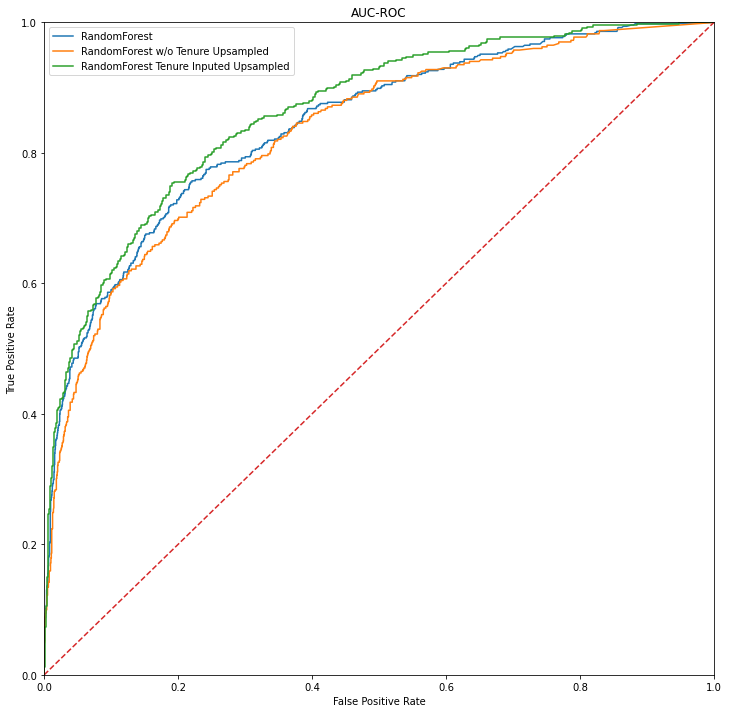

In [364]:
fpr_dec_tree_best, tpr_dec_tree_best, thresholds_dec_tree_best = roc_curve(
                                                                      target_test, probabilities_one_val_rfc_best)
fpr_dec_tree_rfc_best, tpr_dec_tree_rfc_best, thresholds_dec_tree_rfc_best = roc_curve(target_no_tenure_test,
                                                                        probabilities_no_tenure_one_test_rfc_best)
fpr_dec_tree_rfc_best_inp, tpr_dec_tree_rfc_best_inp, thresholds_dec_tree_rfc_best_inp = roc_curve(
                                       target_inputed_tenure_test, probabilities_inputed_tenure_one_test_rfc_best)
plt.figure(figsize=(12, 12))
plt.plot(fpr_dec_tree, tpr_dec_tree, label='RandomForest')
plt.plot(fpr_dec_tree_rfc_best, tpr_dec_tree_rfc_best, label='RandomForest w/o Tenure Upsampled')
plt.plot(fpr_dec_tree_rfc_best_inp, tpr_dec_tree_rfc_best_inp, label='RandomForest Tenure Inputed Upsampled')
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC')
plt.show()

## Выводы:
- Лучшие значения F1-меры получили для модели "Случайный лес"
- В борьбе с дисбалансом лучше всего себя проявила техника upsample для моделей случайный лес
- Для логистической регрессии явного фаворита в борьбе с дисбалансом нет: любой подход для решения проблемы с дисбалансом классов значительно повышал значение F1-меры
- В данной задаче подход по удалению одной колонки с пустыми значениями с признаком, который не является сильно важным, привел к чуть более точным результатам, чем удаление строк с пустыми значениями, когда как импутация данных, полученных линейной регрессией, показала наилучший результат: F1 = 0.624, AUC-ROC = 0.862

## Тестирование моделей градиентного бустинга


> Ансамблевые модели стали стандартным инструментом для предсказательного моделирования. Бустинг — это общая методика создания ансамбля моделей. Она была разработана примерно в то же время, что и бэггинг. Подобно бэггингу, бустинг очень широко используется с деревьями решений. Несмотря на их общие черты, в бустинге принят совсем другой подход, который сопровождается многими излишними аксессуарами. В результате в то время как бэггинг можно применять с относительно небольшой донастройкой, бустинг требует в своем применении намного большей внимательности.

Протестируем бутстрапированный upsampled датасет с замещенными пропусками в колонке `Tenure` на трех моделях градиентного бустинга `XGBClassifier`, `LGBMClassifier`, `CatBoostClassifier`.

In [80]:
# напишем функцию для моделей с использованием GridSearchCV()

def get_best_model(model, params, x_train, x_test, y_train, y_test, score=make_scorer(f1_score)):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    best_model.fit(x_train, y_train)
    predicted = best_model.predict(x_test)
    # вычислим значение полноты, точности и F1-меры нашей модели

    # accuracy = accuracy_score(y_test, predicted)
    # recall = recall_score(y_test, predicted)
    # precision = precision_score(y_test, predicted)
    # f1 = f1_score(y_test, predicted)
    # вычислим значение AUC-ROC
    probabilities = best_model.predict_proba(x_test)[:, 1]
    # probabilities_1 = probabilities[:, 1]
    # auc_roc = roc_auc_score(y_test, probabilities)
    # metrics['auc-roc'] = auc_roc
    metrics = {metric: f(y_test, predicted if metric != 'auc-roc' else probabilities) 
                            for metric, f in zip(['accuracy', 'recall', 'precision', 'f1', 'auc-roc'],
                                                 [accuracy_score, recall_score, precision_score,
                                                                            f1_score, roc_auc_score])}
    print('Лучшие параметры модели:', grid.best_params_, end='\n')
    report = pd.DataFrame(metrics.values(), index=metrics.keys(), columns=['Значения метрик'])
    return best_model, report

## XGBoost

> XGBoost — это наиболее широко используемый бесплатный пакет программ с реализацией стохастического градиентного бустинга, который первоначально был разработан Тьянси Ченом (Tianqi Chen) и Карлосом Гестрином (Carlos Guestrin) в Вашингтонсоком университете. Его вычислительно эффективная реализация со многими опциями доступна в качестве программной библиотеки для большинства основных языков программирования, используемых в науке о данных. В Python XGBoost доступен в виде программного пакета `xgboost`.
> Функция xgboost имеет много параметров, которые могут и должны корректироваться. Двумя очень важными параметрами являются `subsample`, управляющий долей наблюдений, которые должны отбираться во время каждой итерации, и `eta` — фактор сжатия, применяемый к $α_{m}$ в алгоритме бустинга. Использование `subsample` заставляет бустинг действовать как случайный лес за исключением того, что отбор выполняется без возврата. Параметр сжатия `eta` полезен для предотвращения переподгонки путем сокращения изменений в весах (меньшее изменение в весах означает, что алгоритм с меньшей вероятностью будет переподогнан к тренировочному набору).

In [58]:
param_xgb = {
    "n_estimators": range(1, 51, 10),
    "max_depth": range(1, 31, 10),
    "eta": np.arange(0.1, 1, 0.1),
}
# используем функцию get_best_model()
xgb_model, df_xgb = get_best_model(
    xgb.XGBClassifier(learning_rate=0.05),
    param_xgb,
    features_inputed_tenure_upsampled,
    features_inputed_tenure_val,
    target_inputed_tenure_upsampled,    
    target_inputed_tenure_val
)

Лучшие параметры модели: {'eta': 0.1, 'max_depth': 21, 'n_estimators': 41}


In [59]:
df_xgb

,Значения метрик
accuracy,0.829000
recall,0.588372
precision,0.605263
f1,0.596698
auc-roc,0.841014


### Гиперпараметры XGBoost
Гиперпараметры в XGBoost используют преимущественно для того, чтобы сбалансировать переподгонку с точностью и вычислительной сложностью.
- `eta` — фактор сжатия в диапазоне 0–1, применяемый к $α$ в алгоритме бустинга. Значение по умолчанию равно 0,3, но для шумных данных рекомендуются меньшие значения (например, 0,1).
- `nrounds` — число циклов бустинга. Если параметр eta установлен в малое значение, важно увеличить число циклов, поскольку алгоритм медленнее обучается. При условии что для предотвращения переподгонки вводятся несколько параметров, наличие большего количества циклов вреда не причинит.
- `max_depth` — максимальная глубина дерева (значение по умолчанию равняется 6). В отличие от случайного леса, который выполняет подгонку очень глубоких деревьев, бустинг обычно осуществляет подгонку мелких деревьев. Это дает преимущество предотвращения мнимых сложных взаимодействий в модели, которые могут возникнуть из-за шумных данных.
- `subsample` и `colsample_bytree` — доля записей для отбора без возврата и доля предикторов для отбора с целью использования в подгонке деревьев. Данные параметры аналогичны параметрам в случайных лесах и помогают предотвратить переподгонку.
- `lambda` и `alpha` — параметры регуляризации для помощи в управлении переподгонкой.

```Python 
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}```

## LGBM

In [85]:
# создадим словарь для lightgbm
param_lgb = {
    "n_estimators": range(1, 101, 10),
    "max_depth": range(1, 31, 10),
    "num_leaves": range(50, 90, 10),
    "subsample": [0.2]
}

# используем функцию get_best_model()
lgb_model, df_lgb = get_best_model(
    lgb.LGBMClassifier(
        boosting_type="gbdt",
        objective="binary",
        learning_rate=0.05
    ),
    param_lgb,
    features_inputed_tenure_upsampled,
    features_inputed_tenure_val,
    target_inputed_tenure_upsampled,    
    target_inputed_tenure_val
)
df_lgb

Лучшие параметры модели: {'max_depth': 21, 'n_estimators': 91, 'num_leaves': 80, 'subsample': 0.2}


,Значения метрик
accuracy,0.818500
recall,0.646512
precision,0.568507
f1,0.605005
auc-roc,0.854742


## CatBoost

In [87]:
%%time
# создадим словарь для catboost
param_ctb = {
    "depth": range(1, 21, 2),
}
# используем функцию get_best_model()
ctb_model, df_ctb = get_best_model(
    ctb.CatBoostClassifier(iterations=100, learning_rate=0.05, logging_level='Silent'),
    param_ctb,
    features_inputed_tenure_upsampled,
    features_inputed_tenure_val,
    target_inputed_tenure_upsampled,    
    target_inputed_tenure_val
)
df_ctb

Лучшие параметры модели: {'depth': 15}
CPU times: user 14min 31s, sys: 9min 54s, total: 24min 26s
Wall time: 17min 6s


,Значения метрик
accuracy,0.813000
recall,0.655814
precision,0.555118
f1,0.601279
auc-roc,0.850576


## Выводы
Лучшее значение F1-меры оказалось равным 0.601. Это значение удалось достичь для модели CatBoost с помощью техники upsampling, приблизительно такое же значение показала модель LightGBM. XGBoost показал результат немного хуже — 0.596.

## 5. Изменение порога
По умолчанию значение порога равно 0.5. Что, если мы поменяем это значение, может быть наша модель станет лучше?

In [115]:
# напишем функцию, которая принимает на вход модель и возвращает значение f1-меры и значение порога. 
def f1_threshold(model, features_valid, target_valid):
    # воспользуемся функцией predict_proba()
    predicted_valid = model.predict(features_valid)
    # значения вероятности классов для валидационной выборки
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    # переберем значения порогов от 0 до 1 с шагом в 0.01
    best_f1 = 0
    for threshold in np.arange(0, 1, 0.01):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
    print('Лучшее значение F1-меры - {:.4f} модели {} - достигается при значении порога - {:.2f}'.format(best_f1,
                                                                                                 model.__class__,
                                                                                                 best_threshold))
    predicted_valid = probabilities_one_valid > best_threshold
    return best_f1, best_threshold, probabilities_valid, probabilities_one_valid, predicted_valid

In [92]:
b_models = [ctb_model, lgb_model, xgb_model]
b_names = ['CatBoost', 'LGBM', 'XGBoost']

In [116]:
models_dict = dict()
for name, model in zip(b_names, b_models):
    models_dict[name] = f1_threshold(model, features_inputed_tenure_val, target_inputed_tenure_val)

Лучшее значение F1-меры - 0.6107 модели <class 'catboost.core.CatBoostClassifier'> - достигается при значении порога - 0.53
Лучшее значение F1-меры - 0.6217 модели <class 'lightgbm.sklearn.LGBMClassifier'> - достигается при значении порога - 0.58
Лучшее значение F1-меры - 0.5993 модели <class 'xgboost.sklearn.XGBClassifier'> - достигается при значении порога - 0.47


## Визуализация метрик

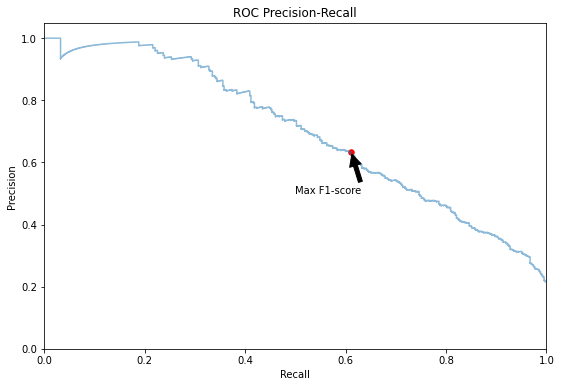

In [151]:
#построим PR-кривую
precision, recall, thresholds = precision_recall_curve(target_inputed_tenure_val, models_dict['LGBM'][2][:,1])
recall_t = recall_score(target_inputed_tenure_val, models_dict['LGBM'][-1])
precision_t = precision_score(target_inputed_tenure_val, models_dict['LGBM'][-1])

plt.figure(figsize=(9, 6))
plt.step(recall, precision, where='post', alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC Precision-Recall')
plt.scatter(recall_t, precision_t, color='red', s=30)
plt.annotate('Max F1-score', 
             xy=(recall_t, precision_t), 
             xytext=(0.5, 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05)
             )
plt.show()

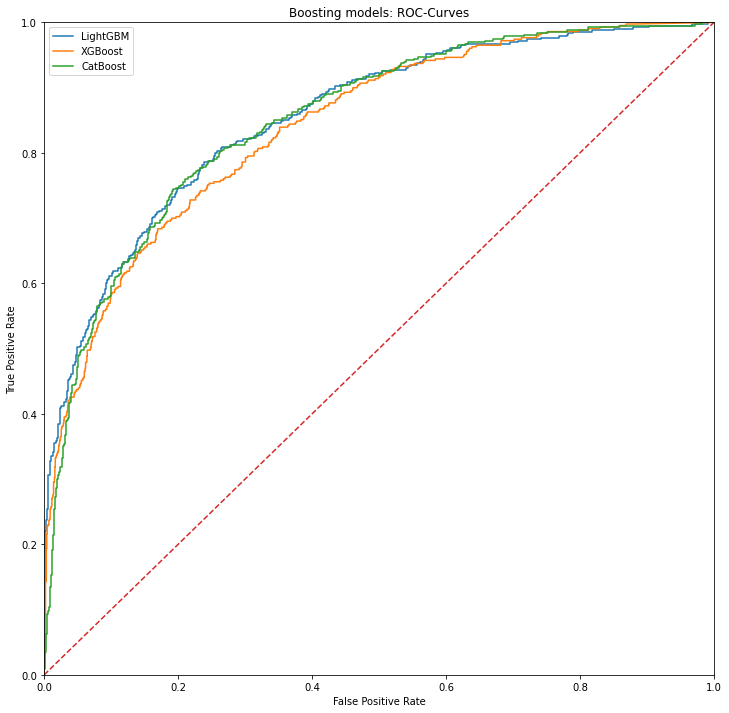

In [159]:
# построим ROC-кривые для моделей бустинга

fpr_lgbm, tpr_lgbm, _ = roc_curve(
    target_inputed_tenure_val, models_dict['LGBM'][-2])
fpr_xgb, tpr_xgb, _ = roc_curve(
    target_inputed_tenure_val, models_dict['XGBoost'][-2])
fpr_ctb, tpr_ctb, _ = roc_curve(
    target_inputed_tenure_val, models_dict['CatBoost'][-2])

plt.figure(figsize=(12, 12))
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_ctb, tpr_ctb, label='CatBoost')

plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Boosting models: ROC-Curves')
plt.show()

## Вывод

Модель случайного леса обученная на данных с импутированными пропусками признака `Tenure` показала лучшие метрики F1 и AUC, равные 0.624 и 0.862 соответственно. Бустинговые модели оказались чуть хуже; лучшая из них — LightGBM — F1 0.6217 и AUC 0.855.

## 6. Тестирование модели

In [162]:
# значения вероятности классов для тестовой выборки
probabilities_test = lgb_model.predict_proba(features_inputed_tenure_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > 0.58
round(f1_score(target_inputed_tenure_test, predicted_test), 4)

0.6098

## 7. Общий вывод
В данной работе была получена модель, которая прогнозирует, уйдёт клиент из банка в ближайшее время или нет.

Лучшая модель — модель ансамблевая модель случайного леса.

Также были исследованы модели логистической регрессии, решающего дерева, и основные модели градиентного бустинга LightGBM, XGBoost, CatBoost.

После балансировки классов техникой увеличения / уменьшения выборки, значение метрики F1 почти у всех исследуемых моделей увеличилось.

F1-меру удалось поднять еще немного благодаря изменению порога до значения 0.58. F1-мера тем самым увеличилась до 0.624.

Значение AUC-ROC 0.862  говорит о том, что наша модель значительно отличается от случайной, т.к. чем график выше, тем больше значение TPR и, соответственно, лучше качество модели.

На тестовой выборке модель показала устойчивость к переобучению: значение F1-меры снизилось до 0.6098.